In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import polars as pl
import gc
from tqdm.auto import tqdm 
import joblib


import xgboost as xgb
import lightgbm as lgb
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/make-data/test_series.csv
/kaggle/input/make-data/train_series.parquet
/kaggle/input/make-data/__results__.html
/kaggle/input/make-data/__resultx__.html
/kaggle/input/make-data/__notebook__.ipynb
/kaggle/input/make-data/__output__.json
/kaggle/input/make-data/test_series.parquet
/kaggle/input/make-data/custom.css
/kaggle/input/make-data/__results___files/__results___9_0.png
/kaggle/input/make-data/__results___files/__results___10_0.png
/kaggle/input/child-mind-institute-detect-sleep-states/train_series.parquet
/kaggle/input/child-mind-institute-detect-sleep-states/sample_submission.csv
/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv
/kaggle/input/child-mind-institute-detect-sleep-states/test_series.parquet


In [3]:
data = pl.read_parquet('/kaggle/input/make-data/train_series.parquet')


In [4]:
data

series_id,step,timestamp,anglez,enmo,awake,lids,year,month,day,hour,minute,second,time_zone,weekday,signal_onset,signal_awake,hour_minute,enmo_1m_mean,enmo_1m_max,enmo_1m_std,enmo_1v_1m_mean,enmo_1v_1m_max,enmo_1v_1m_std,anglez_1m_mean,anglez_1m_max,anglez_1m_std,anglez_1v_1m_mean,anglez_1v_1m_max,anglez_1v_1m_std,enmo_3m_mean,enmo_3m_max,enmo_3m_std,enmo_1v_3m_mean,enmo_1v_3m_max,enmo_1v_3m_std,anglez_3m_mean,…,enmo_1v_30m_std,anglez_30m_mean,anglez_30m_max,anglez_30m_std,anglez_1v_30m_mean,anglez_1v_30m_max,anglez_1v_30m_std,enmo_120m_mean,enmo_120m_max,enmo_120m_std,enmo_1v_120m_mean,enmo_1v_120m_max,enmo_1v_120m_std,anglez_120m_mean,anglez_120m_max,anglez_120m_std,anglez_1v_120m_mean,anglez_1v_120m_max,anglez_1v_120m_std,enmo_480m_mean,enmo_480m_max,enmo_480m_std,enmo_1v_480m_mean,enmo_1v_480m_max,enmo_1v_480m_std,anglez_480m_mean,anglez_480m_max,anglez_480m_std,anglez_1v_480m_mean,anglez_1v_480m_max,anglez_1v_480m_std,anglez_25s_smooth,enmo_25s_smooth,anglez_smooth_lag_30s,anglez_smooth_lag_60s,enmo_smooth_lag_30s,enmo_smooth_lag_60s
str,u32,str,f32,u16,i8,f32,u8,i8,i8,i8,i8,i8,i32,u32,f32,f32,i32,u16,u16,u16,u32,u32,u32,u16,u16,u16,u32,u32,u32,u16,u16,u16,u32,u32,u32,u16,…,u32,u16,u16,u16,u32,u32,u32,u16,u16,u16,u32,u32,u32,u16,u16,u16,u32,u32,u32,u16,u16,u16,u32,u32,u32,u16,u16,u16,u32,u32,u32,f32,f32,f32,f32,f32,f32
"""08db4255286f""",0,"""2018-11-05T10:…",-30.845301,44,1,14.129221,18,11,5,10,0,0,-4,1,4.6365e-26,0.149748,600,55,76,13,114,250,106,33,30,1,9,33,13,57,107,17,150,560,158,31,…,211,27,18,3,18,96,15,74,198,28,207,1230,194,27,16,3,18,96,15,75,992,85,263,7160,451,21,89,43,42,1315,94,-33.514423,56.0,-33.514423,-33.514423,56.0,56.0
"""08db4255286f""",1,"""2018-11-05T10:…",-34.181801,44,1,14.119147,18,11,5,10,0,5,-4,1,4.6365e-26,0.149748,600,62,107,23,188,560,205,33,30,1,15,44,18,57,107,17,154,560,154,30,…,211,27,18,3,17,96,15,74,198,28,207,1230,194,27,16,3,18,96,15,75,992,85,263,7160,451,21,89,43,42,1315,94,-33.514423,56.0,-33.514423,-33.514423,56.0,56.0
"""08db4255286f""",2,"""2018-11-05T10:…",-33.877102,48,1,14.109452,18,11,5,10,0,10,-4,1,4.6365e-26,0.149748,600,62,107,21,222,560,208,32,30,1,13,44,17,58,107,16,147,560,153,30,…,210,27,18,3,18,96,15,74,198,28,206,1230,194,27,16,3,18,96,15,75,992,85,263,7160,451,21,89,43,42,1315,94,-33.514423,56.0,-33.514423,-33.514423,56.0,56.0
"""08db4255286f""",3,"""2018-11-05T10:…",-34.282101,68,1,14.09982,18,11,5,10,0,15,-4,1,4.6365e-26,0.149748,600,61,107,20,215,560,194,32,30,1,14,44,17,58,107,16,140,560,152,30,…,210,27,18,3,18,96,15,74,198,28,207,1230,194,27,16,3,18,96,15,74,992,85,263,7160,451,21,89,43,42,1315,94,-34.330482,57.400002,-33.514423,-33.514423,56.0,56.0
"""08db4255286f""",4,"""2018-11-05T10:…",-34.385799,76,1,14.090398,18,11,5,10,0,20,-4,1,4.6365e-26,0.149748,600,59,107,20,193,560,193,33,30,1,14,44,15,58,107,15,137,560,149,30,…,209,27,18,3,18,96,15,74,198,28,207,1230,194,27,16,3,18,96,15,74,992,85,263,7160,451,21,89,43,42,1315,93,-33.596802,70.0,-33.514423,-33.514423,56.0,56.0
"""08db4255286f""",5,"""2018-11-05T10:…",-34.925598,51,1,14.081073,18,11,5,10,0,25,-4,1,4.6365e-26,0.149748,600,61,107,19,207,560,187,33,30,1,15,44,15,58,107,15,135,560,146,30,…,209,27,18,3,17,96,15,74,198,28,207,1230,194,27,16,3,18,96,15,74,992,85,262,7160,451,21,89,43,42,1315,93,-32.92326,73.199997,-33.514423,-33.514423,56.0,56.0
"""08db4255286f""",6,"""2018-11-05T10:…",-30.513399,107,1,14.071533,18,11,5,10,0,30,-4,1,4.6365e-26,0.149748,600,62,107,19,195,560,181,32,30,1,15,44,14,57,107,15,140,560,144,29,…,208,27,18,3,17,96,15,74,198,28,207,1230,194,27,16,3,18,96,15,74,992,85,263,7160,451,21,89,43,42,1315,93,-32.64296,69.199997,-33.514423,-33.514423,56.0,56.0
"""08db4255286f""",7,"""2018-11-05T10:…",-30.509399,64,1,14.06176,18,11,5,10,0,35,-4,1,4.6365e-26,0.149748,600,63,107,18,190,560,174,32,29,1,15,44,14,57,107,15,140,560,141,29,…,208,26,18,3,17,96,15,74,198,28,207,1230,194,27,16,3,18,96,15,74,992,85,263,7160,451,21,89,43,42,1315,93,-32.700798,63.200001,-33.514423,-33.514423,56.0,56.0
"

In [5]:
def split_train_test(df, n_train):
    ids = df['series_id'].unique(maintain_order = True)
    dict_ids2data = {}

    # for i in range(2):
    for i in tqdm(range(len(ids))):
        print (i,': ', ids[i])
        dict_ids2data[ids[i]] = df.filter(pl.col("series_id") == ids[i])

    train_ = pl.concat([i for i, i_id in zip(dict_ids2data.values(), range(len(ids))) if i_id <= n_train], rechunk=True)
    test_ = pl.concat([i for i, i_id in zip(dict_ids2data.values(), range(len(ids))) if i_id > n_train], rechunk=True)

    del dict_ids2data
    gc.collect()
    
    return train_, test_

def split_Xy_train(df):
    if ('step' in df.columns):
        df = df.drop("step")
    if ('series_id' in df.columns):
        df = df.drop("series_id")
    if ('timestamp' in df.columns):
        df = df.drop("timestamp")
    return df.drop("awake"), df['awake']

train, test = split_train_test(data, 30)

X_train, y_train = split_Xy_train(train)

gc.collect()


  0%|          | 0/35 [00:00<?, ?it/s]

0 :  08db4255286f
1 :  0a96f4993bd7
2 :  0cfc06c129cc
3 :  1087d7b0ff2e
4 :  10f8bc1f7b07
5 :  18b61dd5aae8
6 :  29c75c018220
7 :  3452b878e596
8 :  349c5562ee2c
9 :  3664fe9233f9
10 :  483d6545417f
11 :  55a47ff9dc8a
12 :  5acc9d63b5fd
13 :  5f94bb3e1bed
14 :  655f19eabf1e
15 :  67f5fc60e494
16 :  72bbd1ac3edf
17 :  76237b9406d5
18 :  7822ee8fe3ec
19 :  89bd631d1769
20 :  8e32047cbc1f
21 :  939932f1822d
22 :  9ee455e4770d
23 :  a9a2f7fac455
24 :  a9e5f5314bcb
25 :  af91d9a50547
26 :  b364205aba43
27 :  c535634d7dcd
28 :  c6788e579967
29 :  c68260cc9e8f
30 :  ca730dbf521d
31 :  d150801f3145
32 :  d25e479ecbb7
33 :  d515236bdeec
34 :  d5e47b94477e


0

In [6]:
len(X_train.columns)

92

In [7]:
lgb_opt =  {
    'num_leaves': 204,
    'learning_rate': 0.07649523437092402,
    'random_state': 42
}

my_classifier = lgb.LGBMClassifier(**lgb_opt)
my_classifier.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.07649523437092402, num_leaves=204,
               random_state=42)

In [8]:
# my_classifier.save_model('LGBMClassifier.txt')

joblib.dump(my_classifier, 'LGBMClassifier.pkl')

['LGBMClassifier.pkl']

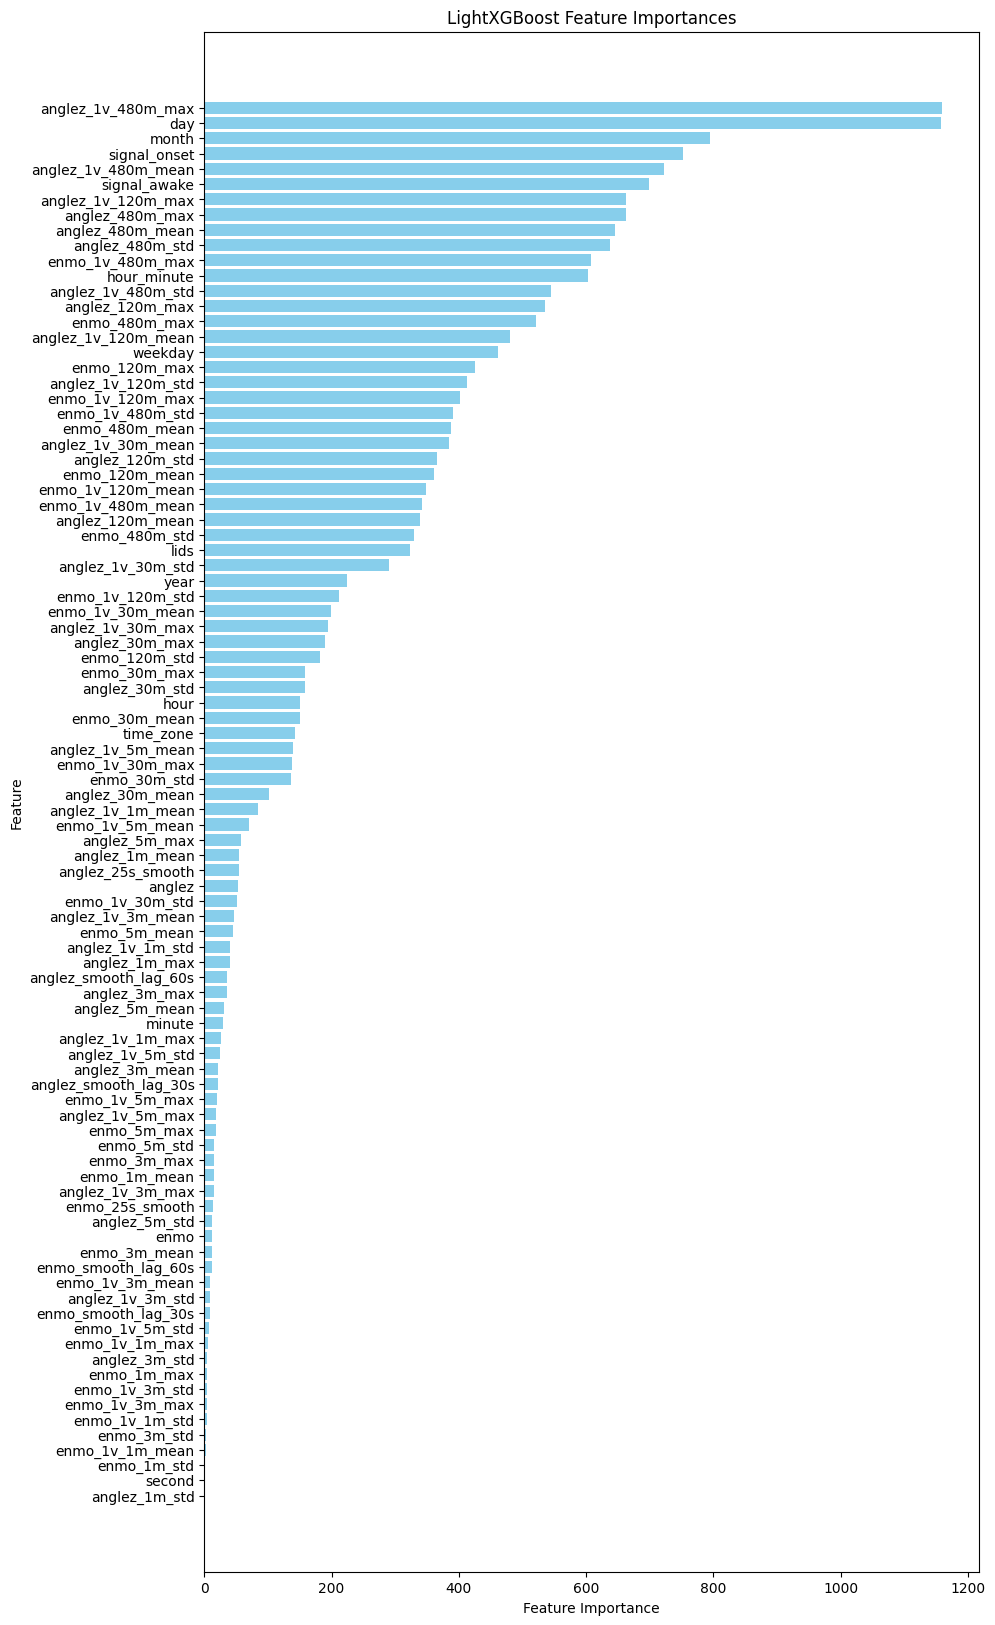

,Feature,Importance
84,anglez_1v_480m_max,1160
5,day,1158
4,month,795
11,signal_onset,752
83,anglez_1v_480m_mean,722
...,...,...
28,enmo_3m_std,3
17,enmo_1v_1m_mean,2
16,enmo_1m_std,1
8,second,0


In [9]:
import matplotlib.pyplot as plt

# Create a DataFrame to store feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': my_classifier.feature_importances_})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Create a bar plot to visualize feature importances
plt.figure(figsize=(10, 20))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('LightXGBoost Feature Importances')
plt.gca().invert_yaxis()  # Invert the y-axis to display the most important features at the top
plt.show()
display(feature_importance_df)

In [10]:
X_test, y_test = split_Xy_train(test)

y_predict_prob = my_classifier.predict_proba(X_test)
y_predict = my_classifier.predict(X_test)

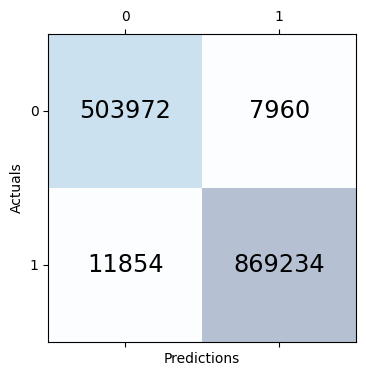

In [11]:
y_pred = y_predict
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions')
plt.ylabel('Actuals')
# plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [14]:
print (f'accuracy {(conf_matrix[0][0] + conf_matrix[1][1]) / (conf_matrix[0][1] + conf_matrix[1][0] + conf_matrix[0][0] + conf_matrix[1][1])}')
print (f'recall {conf_matrix[1][1] / (conf_matrix[1][0] + conf_matrix[1][1])}')
print (f'precision {conf_matrix[1][1] / (conf_matrix[0][1] + conf_matrix[1][1])}')


accuracy 0.9857762271898465
recall 0.9865461792692671
precision 0.9909256105262918


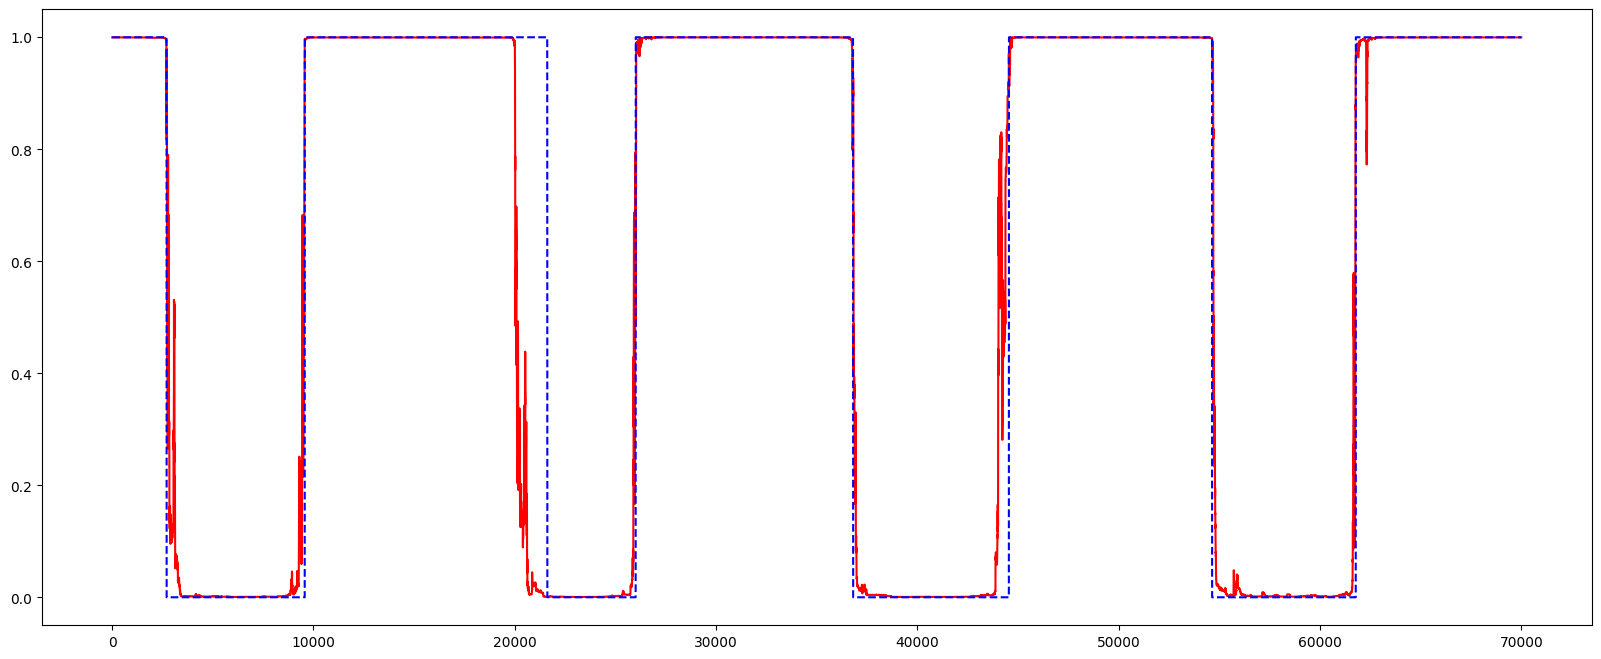

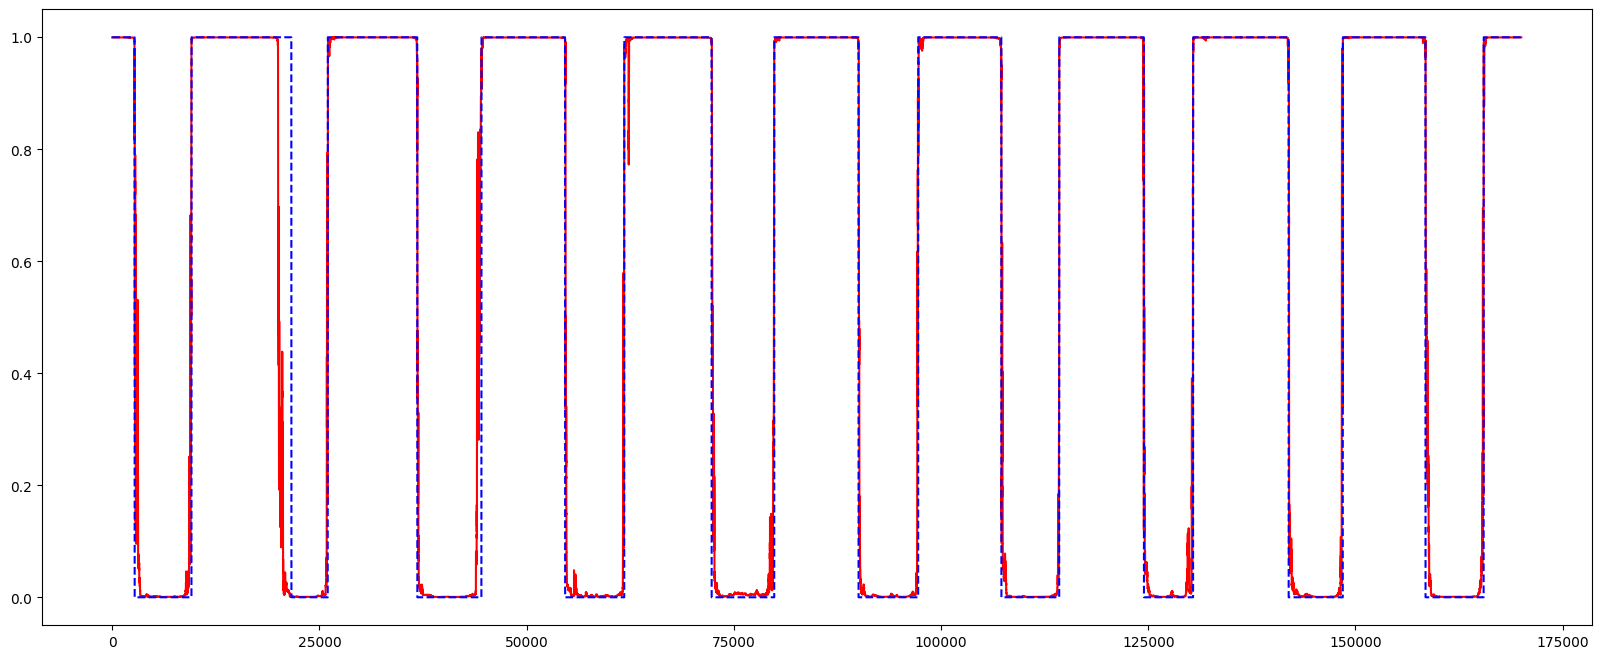

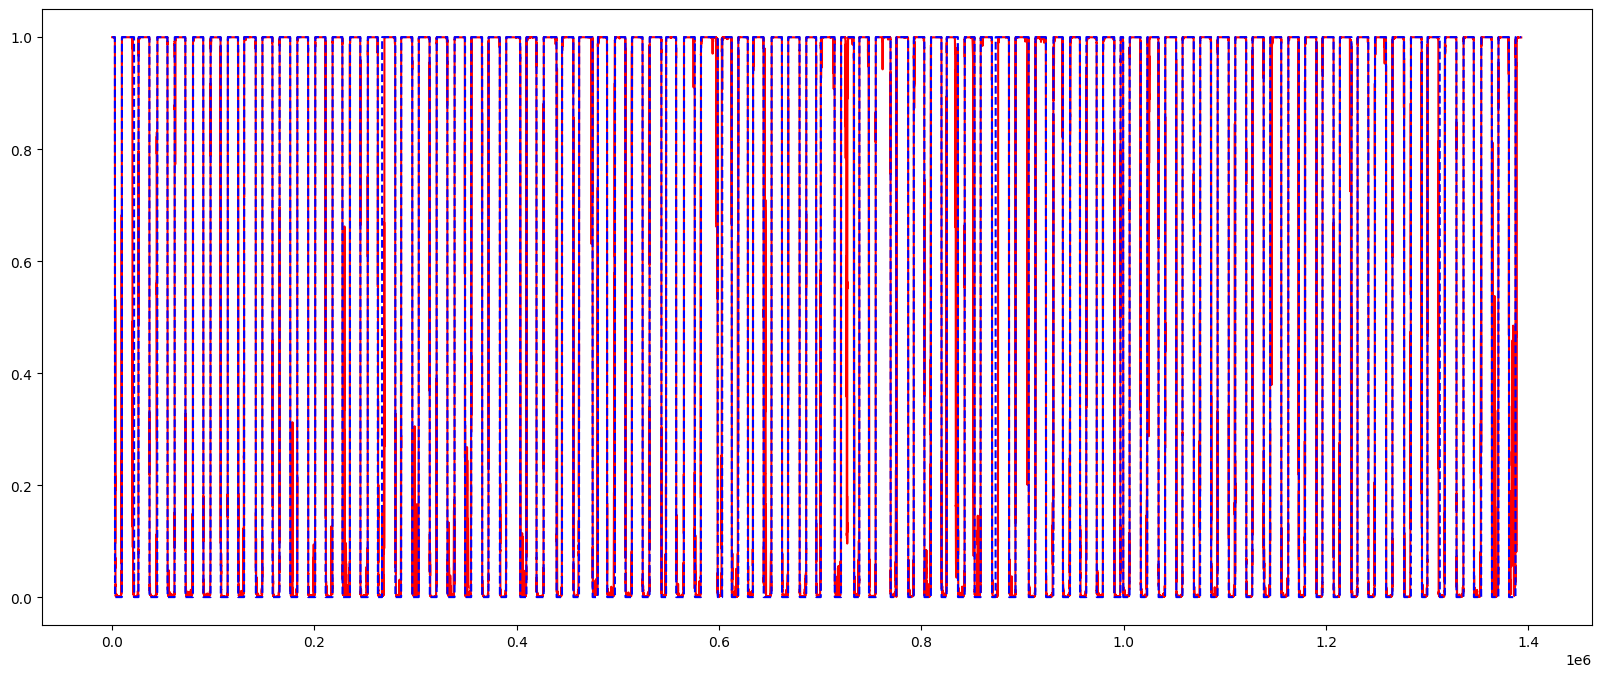

In [13]:
plt.figure(figsize=(20,8))
plt.plot(y_predict_prob[:70000,1], color = 'r')
plt.plot(y_test[:70000], color = 'b', linestyle = 'dashed')
plt.show()

plt.figure(figsize=(20,8))
plt.plot(y_predict_prob[:170000,1], color = 'r')
plt.plot(y_test[:170000], color = 'b', linestyle = 'dashed')
plt.show()

plt.figure(figsize=(20,8))
plt.plot(y_predict_prob[:,1], color = 'r')
plt.plot(y_test[:], color = 'b', linestyle = 'dashed')
plt.show()